In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion
from lib.data import TwoStateMNISTData
from lib.utils import random_split_dataset
import random
import torch.backends.cudnn as cudnn
import warnings

In [6]:
root = './mnist_data'
use_gpu = None
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
trainval_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
train_proportion = 0.8
train_set, val_set = random_split_dataset(trainval_set, [train_proportion, 1-train_proportion])
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [79]:
n_hidden = 30 # 50, 300
n_categories = 10
seed = 42

if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')
    
'''StateMNISTData'''
min_length, max_length = 5, 5
target_function = torch.cat([torch.randperm(n_categories).unsqueeze(0) for _ in range(max_length)], 0)

'''ShiftStateMNISTData'''
'''
offset = [-1,3,5,-2,3]
min_length, max_length = 5, 5
'''

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  if __name__ == '__main__':


'\noffset = [-1,3,5,-2,3]\nmin_length, max_length = 5, 5\n'

In [80]:
target_function

tensor([[2, 6, 1, 8, 4, 5, 0, 9, 3, 7],
        [3, 5, 8, 9, 4, 6, 1, 0, 7, 2],
        [7, 5, 0, 3, 1, 6, 9, 8, 4, 2],
        [9, 2, 5, 1, 4, 3, 7, 0, 8, 6],
        [9, 6, 2, 4, 1, 7, 5, 3, 0, 8]])

### multi output LSTM

In [81]:
from lib.model import RNN_LSTM
from lib.data import StateMNISTData
from lib.train import TrainMORNN

net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'mo_models/lstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=min_length, max_length=max_length)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=min_length, max_length=max_length)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 11%
             31|             0%|          0m 7s|        0.03167|        0.00000|        2.26679
             62|             1%|          0m 8s|        0.03140|        0.00000|        2.21592
             93|             2%|          0m 9s|        0.03435|        0.00000|        2.16319
            124|             3%|         0m 10s|        0.03422|        0.00000|        2.11692
            155|             4%|         0m 11s|        0.03402|        0.00000|        2.07800
            186|             5%|         0m 12s|        0.03297|        0.00000|        2.04401
            217|             6%|         0m 13s|        0.03345|        0.00000|        2.01021
            248|             7%|         0m 14s|        0.03363|        0.00000|        1.98258
            279|             8%|         0m 15s|        0.03330|      

           2480|            79%|          2m 6s|        0.03074|        0.00000|        1.14130
==> evaluating validation accuracy
==> validation accuracy is 80%
           2511|            80%|         2m 13s|        0.03077|        0.00000|        1.13579
           2542|            81%|         2m 14s|        0.03083|        0.00000|        1.12993
           2573|            82%|         2m 15s|        0.03082|        0.00000|        1.12464
           2604|            83%|         2m 16s|        0.03079|        0.00000|        1.11918
           2635|            84%|         2m 17s|        0.03076|        0.00000|        1.11358
           2666|            85%|         2m 18s|        0.03073|        0.00000|        1.10824
           2697|            86%|         2m 19s|        0.03076|        0.00000|        1.10297
           2728|            87%|         2m 20s|        0.03072|        0.00000|        1.09742
           2759|            88%|         2m 21s|        0.03069|      

In [107]:
from lib.model import RNN_MLP
from lib.data import StateMNISTData
from lib.train import TrainMORNN

net = RNN_MLP(784, n_hidden, n_categories)
savename = 'mo_models/mlp.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=min_length, max_length=max_length)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=min_length, max_length=max_length)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 12%
             31|             0%|          0m 8s|        0.03669|        0.00000|        2.21555
             62|             1%|          0m 9s|        0.03510|        0.00000|        2.13304
             93|             2%|          0m 9s|        0.03263|        0.00000|        2.07684
            124|             3%|         0m 10s|        0.03135|        0.00000|        2.04147
            155|             4%|         0m 11s|        0.03110|        0.00000|        2.01312
            186|             5%|         0m 12s|        0.03051|        0.00000|        1.99366
            217|             6%|         0m 13s|        0.03004|        0.00000|        1.97845
            248|             7%|         0m 14s|        0.02969|        0.00000|        1.96588
            279|             8%|         0m 15s|        0.02943|      

           2480|            79%|         2m 10s|        0.03067|        0.00000|        1.84988
==> evaluating validation accuracy
==> validation accuracy is 28%
           2511|            80%|         2m 18s|        0.03068|        0.00000|        1.84947
           2542|            81%|         2m 19s|        0.03077|        0.00000|        1.84936
           2573|            82%|         2m 20s|        0.03078|        0.00000|        1.84891
           2604|            83%|         2m 21s|        0.03075|        0.00000|        1.84846
           2635|            84%|         2m 22s|        0.03083|        0.00000|        1.84796
           2666|            85%|         2m 23s|        0.03094|        0.00000|        1.84766
           2697|            86%|         2m 25s|        0.03102|        0.00000|        1.84736
           2728|            87%|         2m 26s|        0.03107|        0.00000|        1.84701
           2759|            88%|         2m 27s|        0.03110|      

accuracy is 93.24%


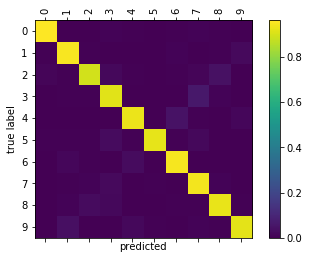

In [8]:
from lib.evaluation import Evaluation
n_categories = 10
test_data = TwoStateMNISTData(test_set)
test_data.set_seq_length(min_length=1, max_length=3)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### MoW

In [82]:
from lib.model import RNN_LSTM_MoW
from lib.train import TrainMORNN

net = RNN_LSTM_MoW(784, n_hidden, n_categories)
net.setKT(2,max_length)
savename = 'mo_models/lstm_mow.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy


/data/jiaxuan/sequence_fun/lib/model.py:46: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  o, hidden = self.model(x, hidden)


==> validation accuracy is 12%
             31|             0%|         0m 28s|        0.08306|        0.00000|        2.26411
             62|             1%|         0m 30s|        0.07447|        0.00000|        2.20171
             93|             2%|         0m 32s|        0.07745|        0.00000|        2.14030
            124|             3%|         0m 35s|        0.07969|        0.00000|        2.07837
            155|             4%|         0m 37s|        0.07819|        0.00000|        2.01767
            186|             5%|         0m 39s|        0.07576|        0.00000|        1.96326
            217|             6%|         0m 41s|        0.07392|        0.00000|        1.90955
            248|             7%|         0m 43s|        0.07222|        0.00000|        1.85727
            279|             8%|         0m 45s|        0.07113|        0.00000|        1.80901
            310|             9%|         0m 47s|        0.07112|        0.00000|        1.76125
==> evalu

==> validation accuracy is 91%
           2511|            80%|         6m 54s|        0.07374|        0.00000|        0.69710
           2542|            81%|         6m 57s|        0.07392|        0.00000|        0.69230
           2573|            82%|         6m 59s|        0.07409|        0.00000|        0.68795
           2604|            83%|          7m 2s|        0.07422|        0.00000|        0.68349
           2635|            84%|          7m 4s|        0.07415|        0.00000|        0.67917
           2666|            85%|          7m 7s|        0.07419|        0.00000|        0.67505
           2697|            86%|          7m 9s|        0.07427|        0.00000|        0.67072
           2728|            87%|         7m 12s|        0.07436|        0.00000|        0.66650
           2759|            88%|         7m 14s|        0.07442|        0.00000|        0.66240
           2790|            89%|         7m 16s|        0.07419|        0.00000|        0.65842
==> evalu

In [102]:
from lib.model import RNN_MLP_MoW
from lib.train import TrainMORNN

net = RNN_MLP_MoW(784, n_hidden, n_categories)
net.setKT(2,5)
savename = 'mo_models/mlp_mow.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 15%
             31|             0%|         0m 18s|        0.05745|        0.00000|        2.20525
             62|             1%|         0m 19s|        0.05044|        0.00000|        2.12300
             93|             2%|         0m 20s|        0.04796|        0.00000|        2.04325
            124|             3%|         0m 22s|        0.04668|        0.00000|        1.98017
            155|             4%|         0m 23s|        0.04602|        0.00000|        1.92780
            186|             5%|         0m 25s|        0.04609|        0.00000|        1.87589
            217|             6%|         0m 26s|        0.04734|        0.00000|        1.82862
            248|             7%|         0m 28s|        0.04691|        0.00000|        1.79033
            279|             8%|         0m 29s|        0.04832|      

           2480|            79%|         4m 38s|        0.05902|        0.00000|        1.06925
==> evaluating validation accuracy
==> validation accuracy is 76%
           2511|            80%|         4m 57s|        0.05914|        0.00000|        1.06588
           2542|            81%|         4m 59s|        0.05919|        0.00000|        1.06227
           2573|            82%|          5m 1s|        0.05925|        0.00000|        1.05876
           2604|            83%|          5m 3s|        0.05914|        0.00000|        1.05563
           2635|            84%|          5m 5s|        0.05911|        0.00000|        1.05254
           2666|            85%|          5m 6s|        0.05907|        0.00000|        1.04897
           2697|            86%|          5m 9s|        0.05921|        0.00000|        1.04594
           2728|            87%|         5m 11s|        0.05927|        0.00000|        1.04290
           2759|            88%|         5m 13s|        0.05933|      

In [19]:
torch.nn.functional.softmax(net.coef, 1)

tensor([[0.7919, 0.2081],
        [0.4385, 0.5615],
        [0.3919, 0.6081]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### shared 

In [88]:
from lib.model import RNN_SLSTM
from lib.train import TrainMORNN

net = RNN_SLSTM(784, n_hidden, n_categories)
net.set_shared_groups([[0,1,2], [3, 4]])
savename = 'mo_models/lstm_shared.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 11%
             31|             0%|         0m 11s|        0.03935|        0.00000|        2.21818
             62|             1%|         0m 13s|        0.03959|        0.00000|        2.11759
             93|             2%|         0m 14s|        0.03828|        0.00000|        2.02648
            124|             3%|         0m 15s|        0.03828|        0.00000|        1.94781
            155|             4%|         0m 16s|        0.03924|        0.00000|        1.87880
            186|             5%|         0m 18s|        0.03899|        0.00000|        1.81709
            217|             6%|         0m 19s|        0.03893|        0.00000|        1.76433
            248|             7%|         0m 20s|        0.03929|        0.00000|        1.71207
            279|             8%|         0m 21s|        0.03850|      

           2480|            79%|         2m 59s|        0.03781|        0.00000|        0.68488
==> evaluating validation accuracy
==> validation accuracy is 91%
           2511|            80%|         3m 11s|        0.03775|        0.00000|        0.68057
           2542|            81%|         3m 12s|        0.03778|        0.00000|        0.67639
           2573|            82%|         3m 13s|        0.03781|        0.00000|        0.67260
           2604|            83%|         3m 15s|        0.03784|        0.00000|        0.66854
           2635|            84%|         3m 16s|        0.03788|        0.00000|        0.66454
           2666|            85%|         3m 17s|        0.03792|        0.00000|        0.66069
           2697|            86%|         3m 18s|        0.03789|        0.00000|        0.65703
           2728|            87%|         3m 20s|        0.03793|        0.00000|        0.65325
           2759|            88%|         3m 21s|        0.03791|      

In [101]:
from lib.model import RNN_SMLP
from lib.train import TrainMORNN

net = RNN_SMLP(784, n_hidden, n_categories)
net.set_shared_groups([[0,1,2], [3, 4]])
savename = 'mo_models/mlp_shared.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 9%
             31|             0%|          0m 8s|        0.03524|        0.00000|        2.11004
             62|             1%|          0m 9s|        0.03565|        0.00000|        1.93550
             93|             2%|         0m 10s|        0.03596|        0.00000|        1.83038
            124|             3%|         0m 11s|        0.03442|        0.00000|        1.75331
            155|             4%|         0m 12s|        0.03440|        0.00000|        1.69489
            186|             5%|         0m 13s|        0.03462|        0.00000|        1.65375
            217|             6%|         0m 14s|        0.03488|        0.00000|        1.61785
            248|             7%|         0m 15s|        0.03487|        0.00000|        1.59106
            279|             8%|         0m 16s|        0.03458|       

           2480|            79%|         2m 17s|        0.03251|        0.00000|        1.35121
==> evaluating validation accuracy
==> validation accuracy is 43%
           2511|            80%|         2m 26s|        0.03252|        0.00000|        1.35059
           2542|            81%|         2m 27s|        0.03255|        0.00000|        1.34991
           2573|            82%|         2m 28s|        0.03260|        0.00000|        1.34951
           2604|            83%|         2m 29s|        0.03255|        0.00000|        1.34909
           2635|            84%|         2m 30s|        0.03250|        0.00000|        1.34859
           2666|            85%|         2m 30s|        0.03245|        0.00000|        1.34803
           2697|            86%|         2m 31s|        0.03240|        0.00000|        1.34753
           2728|            87%|         2m 32s|        0.03243|        0.00000|        1.34702
           2759|            88%|         2m 33s|        0.03238|      

### independent

In [92]:
from lib.model import RNN_ILSTM
from lib.train import TrainMORNN

net = RNN_ILSTM(784, n_hidden, n_categories)
net.set_max_length(max_length)
savename = 'mo_models/lstm_independent.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 16%
             31|             0%|         0m 12s|        0.03777|        0.00000|        2.16195
             62|             1%|         0m 13s|        0.03735|        0.00000|        1.99855
             93|             2%|         0m 14s|        0.03772|        0.00000|        1.84524
            124|             3%|         0m 15s|        0.03647|        0.00000|        1.70974
            155|             4%|         0m 16s|        0.03569|        0.00000|        1.59406
            186|             5%|         0m 17s|        0.03520|        0.00000|        1.49740
            217|             6%|         0m 18s|        0.03488|        0.00000|        1.41422
            248|             7%|         0m 19s|        0.03461|        0.00000|        1.33862
            279|             8%|         0m 20s|        0.03440|      

           2480|            79%|         2m 57s|        0.03673|        0.00000|        0.44727
==> evaluating validation accuracy
==> validation accuracy is 93%
           2511|            80%|          3m 9s|        0.03675|        0.00000|        0.44467
           2542|            81%|         3m 10s|        0.03675|        0.00000|        0.44229
           2573|            82%|         3m 11s|        0.03670|        0.00000|        0.43986
           2604|            83%|         3m 12s|        0.03666|        0.00000|        0.43747
           2635|            84%|         3m 13s|        0.03661|        0.00000|        0.43523
           2666|            85%|         3m 14s|        0.03657|        0.00000|        0.43294
           2697|            86%|         3m 15s|        0.03655|        0.00000|        0.43067
           2728|            87%|         3m 16s|        0.03661|        0.00000|        0.42825
           2759|            88%|         3m 17s|        0.03663|      

### mlp independent

In [95]:
from lib.model import RNN_IMLP
from lib.train import TrainMORNN

net = RNN_IMLP(784, n_hidden, n_categories)
net.set_max_length(max_length)
savename = 'mo_models/mlp_independent.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=5, max_length=5)
train_data.set_target_function(target_function)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=5, max_length=5)
val_data.set_target_function(target_function)

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 17%
             31|             0%|          0m 8s|        0.03837|        0.00000|        1.95860
             62|             1%|          0m 9s|        0.03430|        0.00000|        1.63450
             93|             2%|         0m 10s|        0.03409|        0.00000|        1.39818
            124|             3%|         0m 11s|        0.03738|        0.00000|        1.22655
            155|             4%|         0m 12s|        0.03633|        0.00000|        1.10379
            186|             5%|         0m 13s|        0.03516|        0.00000|        1.00954
            217|             6%|         0m 14s|        0.03434|        0.00000|        0.93485
            248|             7%|         0m 15s|        0.03369|        0.00000|        0.87932
            279|             8%|         0m 16s|        0.03322|      

           2480|            79%|         2m 23s|        0.03446|        0.00000|        0.39924
==> evaluating validation accuracy
==> validation accuracy is 90%
           2511|            80%|         2m 32s|        0.03451|        0.00000|        0.39845
           2542|            81%|         2m 33s|        0.03446|        0.00000|        0.39751
           2573|            82%|         2m 34s|        0.03440|        0.00000|        0.39656
           2604|            83%|         2m 35s|        0.03440|        0.00000|        0.39545
           2635|            84%|         2m 36s|        0.03433|        0.00000|        0.39423
           2666|            85%|         2m 37s|        0.03427|        0.00000|        0.39358
           2697|            86%|         2m 38s|        0.03420|        0.00000|        0.39267
           2728|            87%|         2m 39s|        0.03419|        0.00000|        0.39166
           2759|            88%|         2m 40s|        0.03418|      

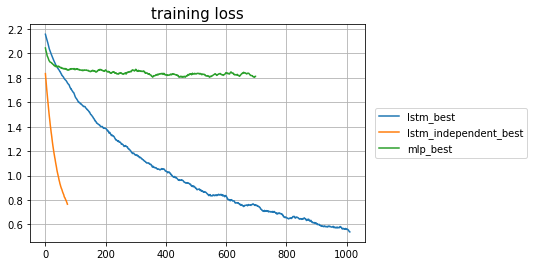

In [111]:
import glob
from lib.train import Train

dummy_trainer = Train(None, None, None, None)
for cpt_fn in glob.glob("mo_models/samples/*_best*"):
    cpt = torch.load(cpt_fn)
    name = cpt_fn.split('.')[0].split('/')[-1]
    l = cpt['train_losses']
    dummy_trainer.all_losses = l
    plt.plot(dummy_trainer.smooth_loss(), label=name)

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('training loss', fontsize=15)
plt.grid()
plt.show()

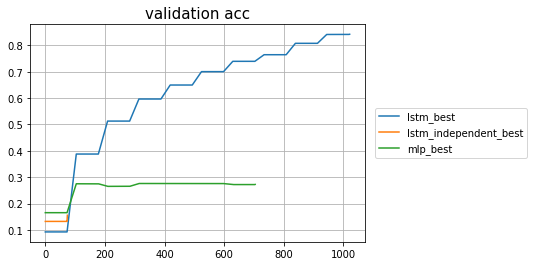

In [112]:
import glob
from lib.train import Train

dummy_trainer = Train(None, None, None, None)
for cpt_fn in glob.glob("mo_models/samples/*_best*"):
    cpt = torch.load(cpt_fn)
    name = cpt_fn.split('.')[0].split('/')[-1]
    l = cpt['val_accs']
    dummy_trainer.val_accs = l
    plt.plot(dummy_trainer.smooth_valacc(), label=name)

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('validation acc', fontsize=15)
plt.grid()
plt.show()